# SG-MCMC Sampling - Hands-on
This notebook implements sgmcmc samplers to test them on simple landscapes. So we are able to get a feeling for their differences and behavior.

In [2]:
import jax.numpy as jnp
import os
import matplotlib.pyplot as plt

from enhancing_sgmcmc.samplers.sghmc import SGHMC
from enhancing_sgmcmc.utils import (
    process_init_m,
    generate_gmm_data,
    gmm_grad,
    run_sequential_sghmc,
    plot_gmm_sampling,
    plot_mcmc_sampling,
)
from enhancing_sgmcmc.metrics import compute_metrics

In [3]:
os.chdir("..")

In [22]:
%load_ext autoreload
%autoreload 2

### Setup

In [4]:
seed = 2

In [5]:
means = jnp.array([[0, 0]])
covs = jnp.array([[[5, 0], [0, 0.2]]])
weights = jnp.array([1.0])
data_samples = 1000

In [9]:
sampler = SGHMC(gmm_grad, means=means, covs=covs, weights=weights)
init_position = jnp.array([2.0, 1.0])

samples = generate_gmm_data(
    seed=seed, means=means, covs=covs, weights=weights, n_samples=data_samples
)

In [7]:
prec_identity = process_init_m("identity", data=samples, means=means, covs=covs, weights=weights)
prec_fisher_approx = process_init_m(
    "fisher_approx", data=samples, means=means, covs=covs, weights=weights
)
prec_fisher_exact = process_init_m(
    "fisher_exact", data=samples, means=means, covs=covs, weights=weights
)

step_size = 0.05
mdecay = 0.02
burnin = 0
n_batches = 5
mcmc_samples = 500

In [10]:
trajectories = []
for i, prec in enumerate([prec_identity, prec_fisher_approx, prec_fisher_exact]):
    trajectory = run_sequential_sghmc(
        sampler=sampler,
        data=samples,
        init_position=init_position,
        init_m=prec,
        batch_size=len(samples) // n_batches,
        mcmc_samples=mcmc_samples,
        step_size=step_size,
        mdecay=mdecay,
        seed=seed,
    )
    trajectories.append(trajectory)

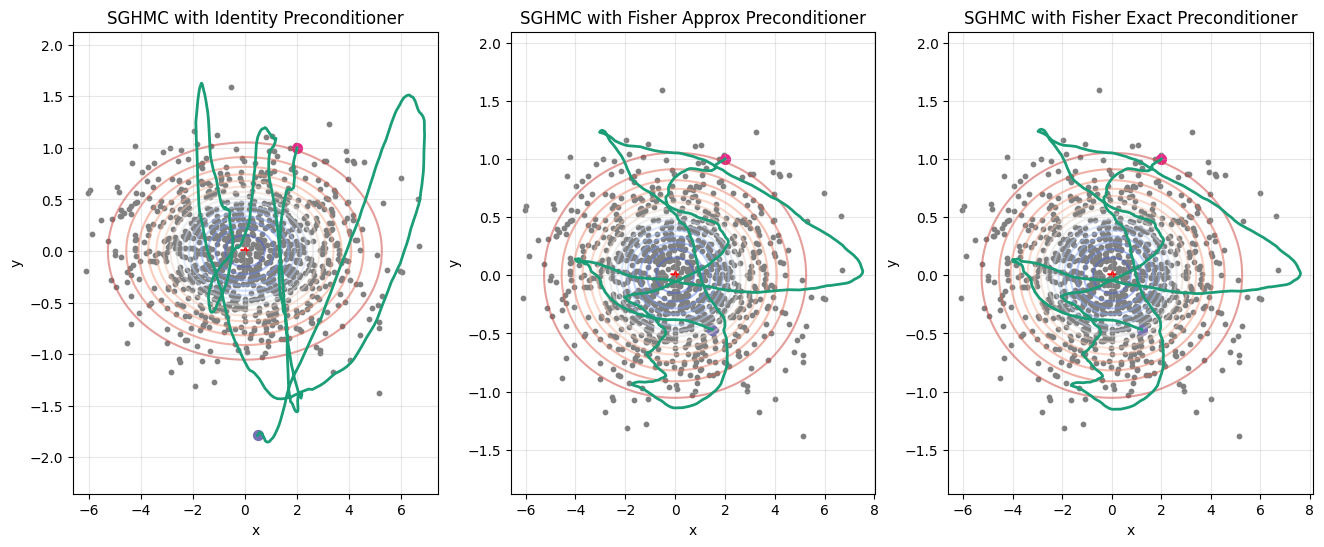

In [126]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for i, trajectory in enumerate(trajectories):
    plot_mcmc_sampling(
        ax=ax[i],
        trajectory=trajectory,
        samples=samples,
        means=means,
        covs=covs,
        weights=weights,
        title=f"SGHMC with {['Identity', 'Fisher Approx', 'Fisher Exact'][i]} Preconditioner",
        show_means=True,
        show_samples=True,
    )

In [18]:
ax[0]

array([<Axes: >, <Axes: >], dtype=object)

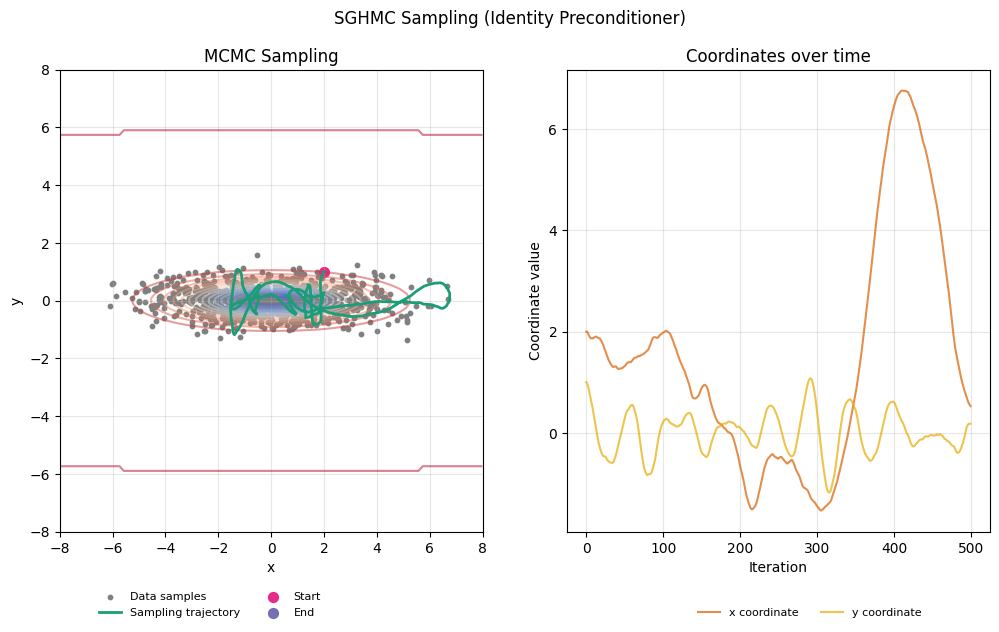

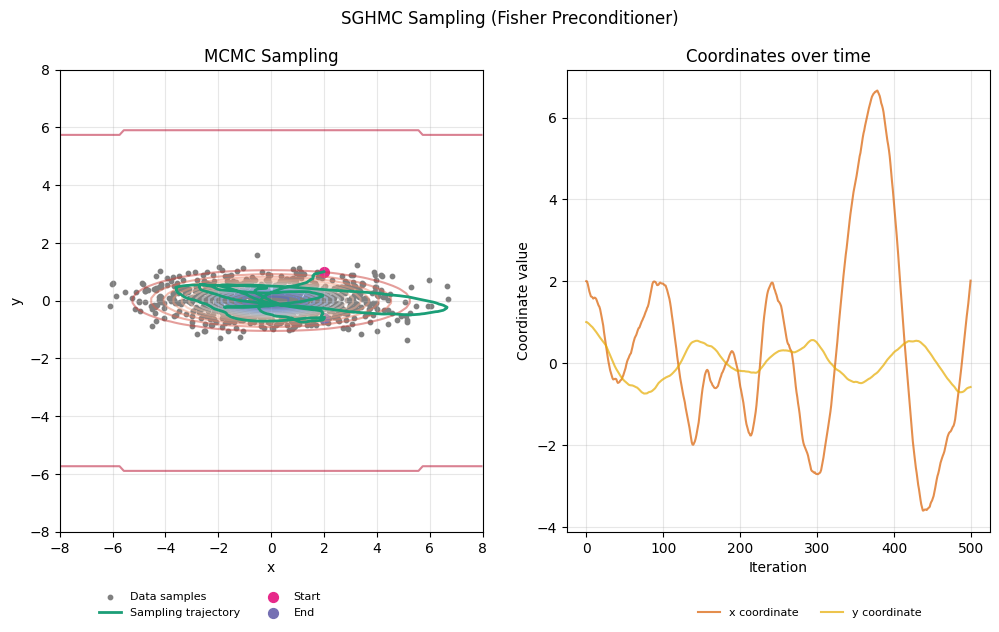

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_gmm_sampling(
    fig=fig,
    ax=ax,
    trajectory=trajectories[0],
    samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    title="SGHMC Sampling (Identity Preconditioner)",
    burnin=burnin,
    plot_type="both",
    xlim=(-8, 8),
    ylim=(-8, 8),
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_gmm_sampling(
    fig=fig,
    ax=ax,
    trajectory=trajectories[1],
    samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    title="SGHMC Sampling (Fisher Preconditioner)",
    burnin=burnin,
    plot_type="both",
    xlim=(-8, 8),
    ylim=(-8, 8),
)

In [46]:
compute_metrics(
    samples=trajectories[0],
    true_samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    metrics=["nll", "ksd", "ess", "wasserstein"],
)

c:\Users\schla\git\enhancing-sgmcmc\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


{'wasserstein': 2.470609251759015e-05,
 'nll': 3.0399491786956787,
 'ksd': 0.26513850688934326,
 'mean_ess': 8.13508415222168,
 'ess_ratio': 0.486122727394104,
 'ess_values': [5.322103023529053, 10.948064804077148]}

In [47]:
compute_metrics(
    samples=trajectories[1],
    true_samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    metrics=["nll", "ksd", "ess", "wasserstein"],
)

c:\Users\schla\git\enhancing-sgmcmc\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


{'wasserstein': 2.4611959815956652e-05,
 'nll': 2.874309539794922,
 'ksd': 0.31945565342903137,
 'mean_ess': 10.36928939819336,
 'ess_ratio': 0.9650995135307312,
 'ess_values': [10.553449630737305, 10.185129165649414]}

In [13]:
# fig.savefig("gmm_sghmc.png", dpi=300, bbox_inches="tight")